In [ ]:
# activate package, basic imports + load data
include("/Users/federicoclaudi/Documents/Github/LocomotionControl/analysis/behavior/analysis_fixtures.jl")
include("/Users/federicoclaudi/Documents/Github/LocomotionControl/analysis/behavior/analysis_visuals.jl")

# Multiple horizons MTM analysis
# include("C:\\Users\\Federico\\Documents\\GitHub\\pysical_locomotion\\analysis\\behavior\\analysis_fixtures.jl")
# include("C:\\Users\\Federico\\Documents\\GitHub\\pysical_locomotion\\analysis\\behavior\\analysis_visuals.jl")

using HypothesisTests
using Random, GLM

import jcontrol: movingaverage
import jcontrol as jc

using GLM
import DataFrames: dropmissing
using Lathe.preprocess: TrainTestSplit


## Get time of slowing/turning

In [ ]:
# initialize empty data store
function initialize_df()
    return Dict(
        "curve_id" => [],
        "class" => [],  # slowing down/turning
        "x" => [],
        "y" => [],
        "s" => [],
        "u" => [],
        "ω" => [],
        "u̇" => [],
        "t0" => [],
        "tpeak" => [],
        "t1" => [],
        "trial_num" => [],
    )
end


function append_data(data_df, trial, I, cidx, class, u̇, t0, tpeak, t1, trial_num)
    push!(data_df["curve_id"], cidx)
    push!(data_df["class"], class)
    push!(data_df["x"], trial.x[I-1])
    push!(data_df["y"], trial.y[I-1])
    push!(data_df["s"], trial.s[I-1])
    push!(data_df["u"], mean(trial.u[I-6:I+5]))
    push!(data_df["ω"], mean(trial.ω[I-6:I+5]))
    push!(data_df["u̇"], u̇ * 60)
    push!(data_df["t0"], t0)
    push!(data_df["tpeak"], tpeak)
    push!(data_df["t1"], t1)
    push!(data_df["trial_num"], trial_num)
end


# get when the mice start slowing down
function get_start_slowing_down(trials, data_df)
    plots = []

    kept = 0
    for cidx in 1:length(curves)
        curve = curves[cidx]
        s0 = curve.s0
        s1 = curve.s
        
        plt = plot()
    
        peaks_s, peaks_values = [], []
        for tn in 1:length(trials)
            trial = trials[tn]
            idxs, idx = get_curve_indices(trial, s0, s1)
    
            u = movingaverage(trial.u, SMOOTHING_WINDOW_LEN)[idxs]
    
            _idxs, _ = get_curve_indices(trial, s0, curve.sf)
            plot!(trial.s[idxs], u, color="black", alpha=.1, label=nothing)
    
            duration = length(u) / 60
            (duration > curve.maxdur || duration < .3) && continue
    
            switchpoint = argmax(u)
            I = switchpoint + idx
            I = max(I, 10)
    
            # get additional info
            info = Dict(
                "mean_u̇" => mean(diff(u[switchpoint:end]))
            )
    
            u̇ = mean(diff(filter(!isnan, u[switchpoint:end])))
            append_data(data_df, trial, I, cidx, "slowing", u̇, idx, I-1, idx+length(u), tn)
            push!(peaks_s, trial.s[I-1])
            push!(peaks_values, trial.u[I-1])
            kept += 1
        end
    
        # scatter position of u̇ peaks
        scatter!(
            peaks_s, peaks_values, color="red", label=nothing, alpha=1
        )
        plot!([s0, s0], [-10, 100], lw=2, color="blue", label="s0", title="Curve $cidx")
        plot!([curve.s, curve.s], [-10, 100], lw=2, color="green", label="apex")
        plot!([curve.sf, curve.sf], [-10, 100], lw=2, color="red", label="curve end")
        push!(plots, plt)
    end
    
    
    
    @info "Kept $kept trials/curves combos"
    return plot(
        plots...; size=(1200, 1000)
    )
end


function get_start_of_turning(trials, data_df)
    plots = []
    kept = 0
    for cidx in 1:length(curves)
        curve = curves[cidx]
        s0 = curve.s0
        s1 = curve.s
        
        plt = plot()

        peaks_s, peaks_values = [], []
        for tn in 1:length(trials)
            trial = trials[tn]
            idxs, idx = get_curve_indices(trial, s0, s1)

            s = movingaverage(trial.s[idxs], SMOOTHING_WINDOW_LEN)
            ω = movingaverage(trial.ω[idxs], SMOOTHING_WINDOW_LEN) .* curve.direction
            plot!(trial.s[idxs], ω, color="black", alpha=.1, label=nothing)

            duration = length(ω) / 60
            (duration > curve.maxdur || duration < .3) && continue

            # get when it starts turning
            th = 2.0
            switchpoint = nothing
            while isnothing(switchpoint) && th > 0
                switchpoint = findfirst((ω .> th) .& (s .> curve.tpos))
                th -= .05
            end

            t0 = findfirst(s .> curve.tpos)
            I = switchpoint + idx

            append_data(data_df, trial, I, cidx, "turning", 0.0, idx+t0, I-1, idx+length(ω), tn)
            push!(peaks_s, trial.s[I-1])
            push!(peaks_values, trial.ω[I-1] * curve.direction)
            kept += 1
        end

        # scatter position of u̇ peaks
        scatter!(
            peaks_s, peaks_values, color="red", label=nothing, alpha=1
        )
        plot!([s0, s0], [-10, 10], lw=2, color="blue", label="s0")

        plot!([curve.s, curve.s], [-10, 10], lw=2, color="green", label="curve", title="Curve $cidx", xlim=[s0, s1], ylim=[-12, 12])
        plot!([curve.tpos, curve.tpos], [-10, 10], lw=2, color="red", label="turn s0")

        hline!([1.5], color="black", lw=2)

        push!(plots, plt)
    end

    @info "Kept $kept trials/curves combos"

    return plot(
        plots..., size=(1200, 1000)
    )

end



In [ ]:
SMOOTHING_WINDOW_LEN = 6


# collect data
data_df = initialize_df()
p1 = get_start_slowing_down(trials, data_df)
p2 = get_start_of_turning(trials, data_df)

# put data together
df = DataFrame(data_df)
df[!,:class] = convert.(String,df[!,:class])

for col in (:curve_id, :t0, :t1, :tpeak, :trial_num)
    df[!,col] = convert.(Int,df[!,col])
end

for col in (:x, :y, :s, :u, :ω, :u̇)
    df[!, col] = convert.(Float64, df[!, col])
end

# display(p1)
# display(p2)

nothing

# F4
Plot accceleration during turn and how much worse it would be if mice didn't slow down

In [ ]:
import jcontrol: Δ, movingaverage

"""
Get average angular acceleration in the 20 frames (.3s)
before reaching peak angular velocity
"""

plots = []
mean_ω̇ = []
for (i, curve) in enumerate(curves)
    slowing = filterdf(df, "curve_id", i, "class", "slowing")

    plt = plot(; grid=false, ylim=[-2, 10], xticks=([1, 18, 24], ["-0.3", "0", "0.1"]))

    curve_mean_ω̇ = []
    for (n, trial) in enumerate(trials)
        n ∈ slowing.trial_num || continue
        _, _, start, stop = get_curve_indices(trial, curve.tpos, curve.sf)

        ω = movingaverage(trial.ω, 2) .* curve.direction
        t = argmax(ω[start:stop]) + start
        # max(ω...) > 20 && continue
        plot!(ω[max(1, t-18):t+6], label=nothing, color="black", alpha=.2)

        push!(curve_mean_ω̇, mean(Δ(ω[max(1, t-20):t])) * 60 * 60)
    end
    push!(mean_ω̇, curve_mean_ω̇)
    push!(plots, plt)
end

plot(plots...; size=(800, 600), link=:all, grid=false)

In [ ]:
# plot KDEs of angular velocity distributions
plots = []

for curve_mean_ω̇ in mean_ω̇
    plt = plot(; grid=false, )
    plot_kde_and_CI!(curve_mean_ω̇, bandwidth = 40)
    plot!( xlabel="angular acceleration (deg/s²)", ylabel="density")
    push!(plots, plt)
end

fig = plot(plots...; size=(800, 600), link=:all, grid=false)
savefig(fig, joinpath(PLOTS_FOLDER, "physics_accelerations.svg"))

fig

plot the change in speed between slowing and turning

In [ ]:
plots = []
speeds_ratios = []
for curve_idx in 1:4
    slowing = filterdf(df, "curve_id", curve_idx, "class", "slowing")
    turning = filterdf(df, "curve_id", curve_idx, "class", "turning")

    # turning = filter(:u̇ => !isnan, turning)
    # slowing = filter(:u̇ => !isnan, slowing)

    prev_u̇ = []
    for slow in eachrow(slowing)
    t0 = max(1, slow.t0-5)
    push!(prev_u̇, mean(diff(trials[slow.trial_num].u)[t0:slow.t0]))
    end

    dt = (turning.tpeak .- slowing.tpeak)
    top_speed = slowing.u .+ prev_u̇ .* dt

    # plt = plot_kde_and_CI(top_speed, bandwidth = 3, color="black", label="no slowing")
    plt = plot_kde_and_CI(slowing.u, bandwidth = 2, color="red", label="slowing")

    plot_kde_and_CI!(turning.u, bandwidth = 2, color="blue", label="turning")
    # plot!(; xlabel="speed cm/s", ylabel="density", title="Curve $curve_idx", legend=true, xlim=[0, 100])

    push!(plots, plt)

    # get speeds ratios
    push!(speeds_ratios, turning.u ./ slowing.u)
end

fig = plot(plots...; size=(800, 600), grid=false)
savefig(fig, joinpath(PLOTS_FOLDER, "physics_speeds.svg"))
fig

compare actual angular acceleration to change if they hadn't slowed down

In [ ]:
plots = []
for k in 1:4
    α_s = mean_ω̇[k] .* speeds_ratios[k]

    plt = plot(xlim=[-40, 150])

    plot_kde_and_CI!( (1 .- speeds_ratios[k]) * 100, bandwidth = 2)
    # plot_kde_and_CI!(mean_ω̇[k], bandwidth = .5, label="α_t")
    # plot_kde_and_CI!(α_s, bandwidth = .5, label="α_s", color="red")
    push!(plots, plt)
end
fig = plot(plots...; size=(800, 600), link=:all, grid=false, xlabel="Δα (%)", ylabel="density")
savefig(fig, joinpath(PLOTS_FOLDER, "physics_accelerations_delta.svg"))
fig

### Do some basic stats

In [ ]:
all_delta_u = []
for curve_idx in 1:4
    slowing = filterdf(df, "curve_id", curve_idx, "class", "slowing")
    turning = filterdf(df, "curve_id", curve_idx, "class", "turning")


    Δu =  @. 100 - (turning.u / slowing.u) * 100
    # Δu = slowing.u .- turning.u
    println("Curve $curve_idx: mean Δu = ", mean(Δu), "% std: ", std(Δu))
    push!(all_delta_u, Δu)
    
end

print("Overall mean Δu = ", mean(vcat(all_delta_u...)), " std: ", std(vcat(all_delta_u...)))


#### Counterfactual
Get the distance from the apex and speed at moment of start turning to compute how much time the mice have to turn. 

In [ ]:
plots = []

for idx in 1:4
    turning = filterdf(df, "curve_id", idx, "class", "turning")
    curve_s = map(idx -> curves[idx].s, turning.curve_id)
    turning[:, "Δs"] = curve_s .- turning.s
    curve = curves[idx]

    T = []
    for (n, trial) in enumerate(trials)
        _, _, start, stop = get_curve_indices(trial, curve.tpos, curve.sf)
        ω = movingaverage(trial.ω, 2) .* curve.direction
        t = argmax(ω[start:stop]) + start
        entry = filterdf(turning, "trial_num", n)
        size(entry, 1) == 0 && continue
        push!(T, (t - entry.tpeak[1])/60)
    end

    plt = plot_kde_and_CI(T, bandwidth = .01, color="blue", label="turning")
    push!(plots, plt)
end

fig = plot(plots...; size=(800, 600), link=:all, grid=false, xlim=[-.5, 1], xlabel="Δt (s)")


given this information compute the angular acceleration the mice should have to make the turn:
$$
\theta = \theta_0 + \omega\_0t + 1/2\alpha t^2
$$

which means that
$$
\alpha = \frac{2}{t^2} (\theta - \theta_0 - \omega t)
$$

In [ ]:
alpha(θ, θ_0, ω, t) = 2/t^2 * (θ - θ_0 - ω*t)

plots = []

for idx in 1:4
    turning = filterdf(df, "curve_id", idx, "class", "turning")
    curve_s = map(idx -> curves[idx].s, turning.curve_id)
    turning[:, "Δs"] = curve_s .- turning.s
    turning[:, "Δt"] = turning.Δs ./ turning.u

    θ = [45, 45, 45, 45/2][idx]
    # θ = deg2rad(θ)

    turning[:, "α"] = alpha.(θ, 0, abs.(rad2deg.(turning.ω)), turning.Δt ./ 2)

    plt = plot_kde_and_CI(turning.α, bandwidth = .1, color="blue", label="turning")
    push!(plots, plt)
end

fig = plot(plots...; size=(800, 600),  grid=false,  xlabel="α", ylabel="density", xlim=[0, 6000])


# F5
Analyse position at slowing down vs deceleration

In [ ]:
slowing = filterdf(df, "class", "slowing")

plots = []

for curve_idx in 1:4
    slowing = filterdf(df, "curve_id", curve_idx, "class", "slowing")
    curve_s = map(idx -> curves[idx].s, slowing.curve_id)
    slowing[:, "Δs"] = curve_s .- slowing.s


    plt = scatter(
        slowing.Δs, slowing.u̇, marker_z=slowing.u, c=:bwr, alpha=1, msw=0.0, label=nothing, ms=3, clims=(25, 100)
    )
    
    plot!(; xlabel="distance (cm)", ylabel="acceleration (cm/s²)", title="Curve $curve_idx", xlim=[-5, 40], legend=false, colorbar_title="speed (cm/s²)")

    push!(plots, plt)
end

fig = plot(plots...; size=(800, 600), link=:all, grid=false)
savefig(fig, joinpath(PLOTS_FOLDER, "slow_u_udot_scatter.svg"))
fig



same polot but pooling the data

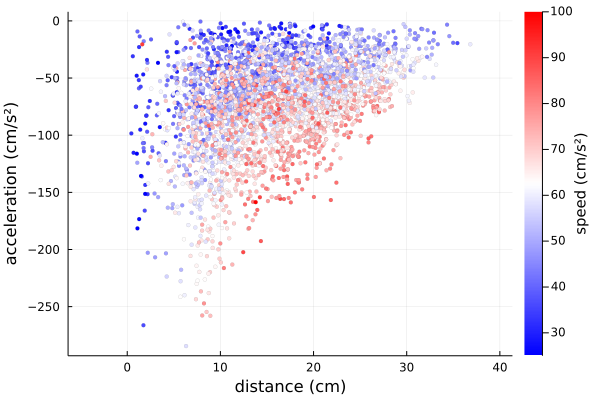

In [147]:
slowing = filterdf(df, "class", "slowing")

ds = []
for curve_idx in 1:4
    curve_slowing = filterdf(df, "curve_id", curve_idx, "class", "slowing")
    curve_s = map(idx -> curves[idx].s, curve_slowing.curve_id)
    append!(ds, curve_s .- curve_slowing.s)
end
slowing[:, "Δs"] = Vector{Float64}(ds)
    

plt = scatter(
    slowing.Δs, slowing.u̇, marker_z=slowing.u, c=:bwr, alpha=1, msw=0.0, label=nothing, ms=3, clims=(25, 100)
)

plot!(; xlabel="distance (cm)", ylabel="acceleration (cm/s²)", xlim=[-5, 40], legend=false, colorbar_title="speed (cm/s²)")
savefig(plt, joinpath(PLOTS_FOLDER, "slow_u_udot_scatter_pooled.svg"))
plt


## Linear model

In [148]:
# Train test split
slowing = filter(:u̇ => !isnan, slowing)

train, test = TrainTestSplit(slowing, .75)

# fit model
fm = @formula(u̇ ~ u + Δs)
linearRegressor = lm(fm, train)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}}}}, Matrix{Float64}}

u̇ ~ 1 + u + Δs

Coefficients:
──────────────────────────────────────────────────────────────────────────
                 Coef.  Std. Error       t  Pr(>|t|)  Lower 95%  Upper 95%
──────────────────────────────────────────────────────────────────────────
(Intercept)  -22.3859    3.13718     -7.14    <1e-11  -28.5375   -16.2344
u             -1.56107   0.0505614  -30.87    <1e-99   -1.66022   -1.46193
Δs             2.86057   0.0945204   30.26    <1e-99    2.67522    3.04591
──────────────────────────────────────────────────────────────────────────

In [149]:
r2(linearRegressor)

0.3686415779986809

In [150]:
# Prediction
ypredicted_test = predict(linearRegressor, test)
ypredicted_train = predict(linearRegressor, train)

# Test Performance DataFrame (compute squared error)
performance_testdf = DataFrame(y_actual = test[!,:u̇], y_predicted = ypredicted_test)
performance_testdf.error = performance_testdf[!,:y_actual] - performance_testdf[!,:y_predicted]
performance_testdf.error_sq = performance_testdf.error.^2

# # Train Performance DataFrame (compute squared error)
# performance_traindf = DataFrame(y_actual = train[!,:u̇], y_predicted = ypredicted_train)
# performance_traindf.error = performance_traindf[!,:y_actual] - performance_traindf[!,:y_predicted]
# performance_traindf.error_sq = performance_traindf.error.^2

# Test Error
println("Mean Absolute test error: ",mean(abs.(performance_testdf.error)), "\n")
println("Mean square test error: ", mean(performance_testdf.error_sq), "\n")

Mean Absolute test error: 22.233409925591236

Mean square test error: 912.8886351977496



In [157]:
fm = @formula(u̇ ~ Δs)
linearRegressor = lm(fm, train)

println(r2(linearRegressor)
)


# Prediction
ypredicted_test = predict(linearRegressor, test)
ypredicted_train = predict(linearRegressor, train)

# Test Performance DataFrame (compute squared error)
performance_testdf = DataFrame(y_actual = test[!,:u̇], y_predicted = ypredicted_test)
performance_testdf.error = performance_testdf[!,:y_actual] - performance_testdf[!,:y_predicted]
performance_testdf.error_sq = performance_testdf.error.^2

println("Mean Absolute test error: ",mean(abs.(performance_testdf.error)), "\n")
println("Mean square test error: ", mean(performance_testdf.error_sq), "\n")

0.14041149623568316
Mean Absolute test error: 27.357339499961846

Mean square test error: 1257.4792346148456



## Deceleration analysis
Compare $\Delta t$ to the max deceleration that mice can do. Start by estimating that from the tracking data

Max deceleration: -160.0 m/s²

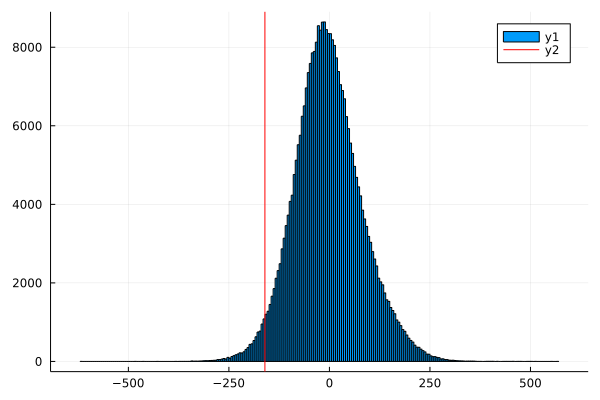

In [134]:
# Estimate mice's acceleration
accelerations = vcat(map(t->diff(movingaverage(t.u, 11)), trials)...) * 60
max_accel = percentile(accelerations, 2.5)

plt = histogram(accelerations)
vline!([max_accel], color="red")

print("Max deceleration: $(round(max_accel)) m/s²")
plt

In [102]:
# compute change in speed and change in time at each curve
Δ_speed, Δ_t = [], []
for curve_idx in 1:4
    slowing = filterdf(df, "curve_id", curve_idx, "class", "slowing")
    turning = filterdf(df, "curve_id", curve_idx, "class", "turning")

    push!(Δ_speed, turning.u .- slowing.u)
    push!(Δ_t, (turning.tpeak .- slowing.tpeak) ./ 60)
end


plot the change in speed over time vs the max possible acceleration

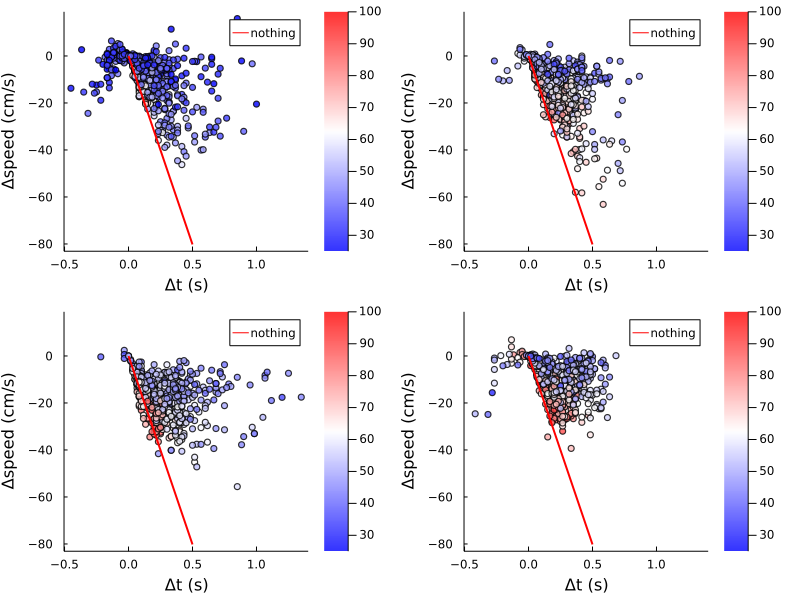

In [135]:
plots = []

for i in 1:4
    slowing = filterdf(df, "curve_id", i, "class", "slowing")

    plt = scatter(Δ_t[i], Δ_speed[i],  marker_z=slowing.u, c=:bwr, alpha=.8, label=nothing, xlabel = "Δt (s)", ylabel = "Δspeed (cm/s)")

    # plot a line marking max deceleration
    plot!(
        [0, .5], [0*max_accel, .5*max_accel], lw=2, color="red", label="nothing", clims=(25, 100)
    )

    push!(plots, plt)
end

fig = plot(plots...; size=(800, 600), link=:all, grid=false)
savefig(fig, joinpath(PLOTS_FOLDER, "slow_turn_Δt_Δs_acc.svg"))
fig

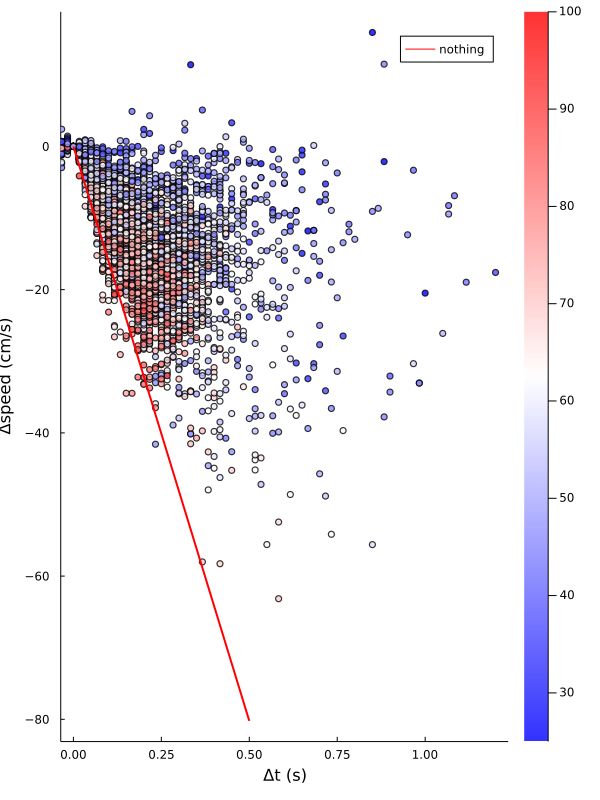

In [104]:
# same but for all data
slowing = filterdf(df, "class", "slowing")

ds = []
for curve_idx in 1:4
    curve_slowing = filterdf(df, "curve_id", curve_idx, "class", "slowing")
    curve_s = map(idx -> curves[idx].s, curve_slowing.curve_id)
    append!(ds, curve_s .- curve_slowing.s)
end
slowing[:, "Δs"] = Vector{Float64}(ds)
    

# the same but plot all curves together
plt = scatter(vcat(Δ_t...), vcat(Δ_speed...),  marker_z=slowing.u, c=:bwr, alpha=.8,   label=nothing, xlabel = "Δt (s)", ylabel = "Δspeed (cm/s)", clims=(25, 100))

plot!(
    [0, .5], [0*max_accel, .5*max_accel], lw=2, color="red", label="nothing"
)

plot!(; xlim=[0, 1.2], grid=false, size=(600, 800))

savefig(plt, joinpath(PLOTS_FOLDER, "slow_turn_Δt_Δs_acc_pooled.svg"))
plt

## Get some basic stats

In [137]:
max_accel

-160.43469278681584

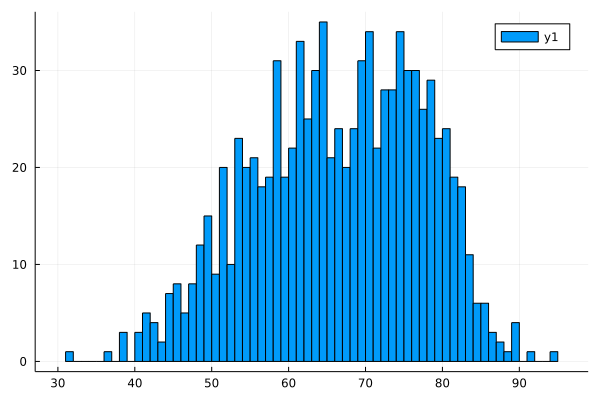

In [138]:
histogram(slowing.u, bins=100)


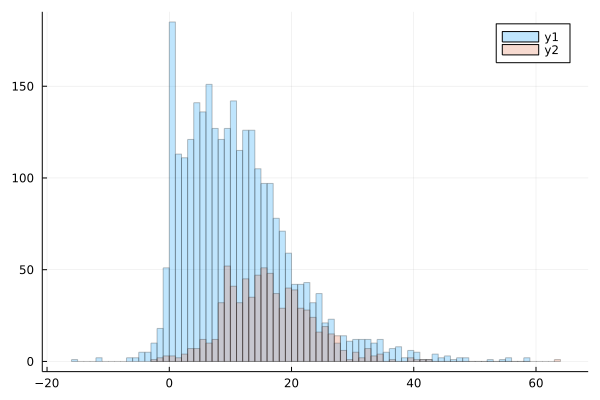

In [139]:

slowing = filterdf(df, "class", "slowing")
turning = filterdf(df, "class", "turning")

slow = findall(slowing.u .< 70)
fast = findall(slowing.u .>= 70)

Δu_byclass = Dict(
    :slow => slowing[slow,:u] .- turning[slow,:u],
    :fast => slowing[fast,:u] .- turning[fast,:u],
)

Δt_byclass = Dict(
    :slow => (slowing[slow,:tpeak] .- turning[slow,:tpeak]) ./ 60,
    :fast => (slowing[fast,:tpeak] .- turning[fast,:tpeak]) ./ 60,
)

histogram(Δu_byclass[:slow, ], alpha=.25, bins=100)
histogram!(Δu_byclass[:fast, ], alpha=.25, bins=100)

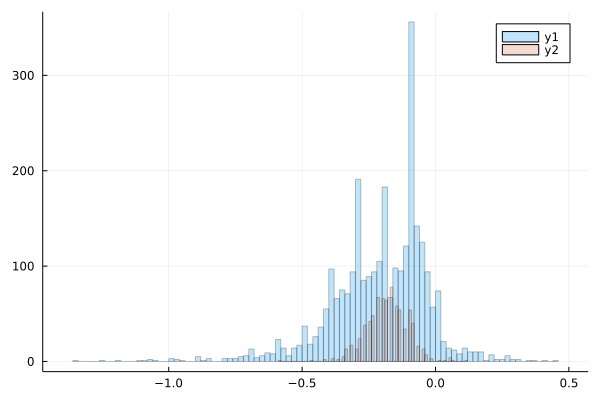

In [140]:
histogram(Δt_byclass[:slow, ], alpha=.25, bins=100)
histogram!(Δt_byclass[:fast, ], alpha=.25, bins=100)

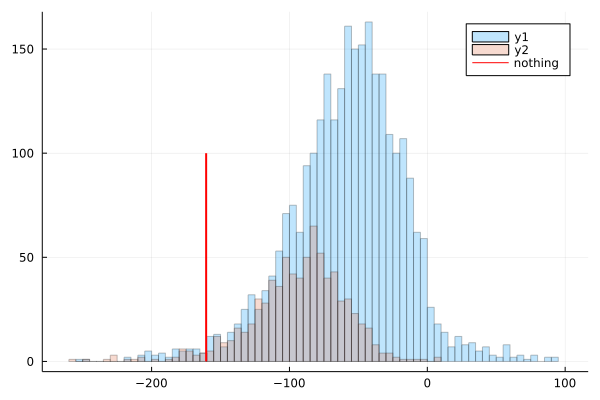

In [141]:

deceleration_by_class = Dict(
    :slow => Δu_byclass[:slow] ./ Δt_byclass[:slow],
    :fast => Δu_byclass[:fast] ./ Δt_byclass[:fast],
)



histogram(deceleration_by_class[:slow, ], alpha=.25, bins=100)
histogram!(deceleration_by_class[:fast, ], alpha=.25, bins=100)
plot!([max_accel, max_accel], [0, 100], lw=2, color="red", label="nothing")

In [142]:
# get the fraction of trials within 10% of acceleration threshold
th = max_accel * .85

slow_strong_accel = length(findall(deceleration_by_class[:slow, ] .<= th)) / length(deceleration_by_class[:slow, ]) * 100
fast_strong_accel = length(findall(deceleration_by_class[:fast, ] .<= th)) / length(deceleration_by_class[:fast, ]) * 100

println("Fraction of slow trials with strong acceleration: ", slow_strong_accel, "%")
println("Fraction of fast trials with strong acceleration: ", fast_strong_accel, "%")

Fraction of slow trials with strong acceleration: 3.882809742322626%
Fraction of fast trials with strong acceleration: 10.505836575875486%


In [143]:
import HypothesisTests: EqualVarianceTTest as ttest

ttest(
    filter(!isnan, deceleration_by_class[:slow, ]),
    filter(!isnan, deceleration_by_class[:fast, ]),
)

Two sample t-test (equal variance)
----------------------------------
Population details:
    parameter of interest:   Mean difference
    value under h_0:         0
    point estimate:          35.9729
    95% confidence interval: (32.77, 39.18)

Test summary:
    outcome with 95% confidence: reject h_0
    two-sided p-value:           <1e-99

Details:
    number of observations:   [2784,771]
    t-statistic:              21.996991028279407
    degrees of freedom:       3553
    empirical standard error: 1.635354029405442


# Error trials (F5)
Define some "boxes" around the start of each curve to select trials that "stop" there.

In [ ]:
import jcontrol: trim
import OrderedCollections: OrderedDict
import jcontrol.trial: trimtrial

speed_th = 5


boxes = Dict(
    1 => (20, 35),
    2 => (70, 85),
    3 => (125, 140),
    4 => (185, 200),
)

boxes_tracks = Dict(
    1 => trim(FULLTRACK, boxes[1][1], boxes[1][2]-boxes[1][1]),
    2 => trim(FULLTRACK, boxes[2][1], boxes[2][2]-boxes[2][1]),
    3 => trim(FULLTRACK, boxes[3][1], boxes[3][2]-boxes[3][1]),
    4 => trim(FULLTRACK, boxes[4][1], boxes[4][2]-boxes[4][1]),
    )


"""
For each box, get which trials stop in there
"""
function get_box_stop_trials(trials)::OrderedDict
    stops = OrderedDict(i=>[] for i in 1:4)
    for trial in trials
        for (i, (s0, sf)) in pairs(boxes)
            if s0 < trial.s[end] < (sf-2)
                push!(stops[i], trial)
            end
        end
    end
    return stops
end




## Look at complete but bad trials

### load and filter the trials

In [ ]:
# import jcontrol.io: load_cached_trials

# load cache incomplete bouts
bad = load_cached_trials(; 
        filter_trials=false
)
@info "Loaded $(length(bad)) bouts"   

In [ ]:
# filter trials that are too short or too slow
bad = filter(b -> max(b.u...) > 60, bad)
bad = filter(b -> b.duration > 2, bad)
@info "After filtering kept $(length(bad)) bad trials"

In [ ]:

# For each trial, get when they slow down below a speed threshold and trim the trial to data

bad_trials = []  # after selecting/trimming trials
for (n, trial) in enumerate(bad)
    stop = findfirst(trial.u .< speed_th)
    isnothing(stop) && continue
    sf = trial.s[stop] 
    15 < sf < 230 || continue
    
    push!(
        bad_trials,
        trimtrial(trial, 1, stop; by=:time)
    )
end

@info "After trimming kept $(length(bad_trials)) bad trials"


stops = get_box_stop_trials(bad_trials)

### plots

In [ ]:
# plot all trials and where they stop
s0s = map(t->t.s[1], bad_trials)
bad_trials = bad_trials[sortperm(s0s)]

plt = plot(; aspect_ratio=:equal, xlim=[0, 40], ylim=[0, 60])
for i in 1:length(bad_trials)
    t = bad_trials[i]
    # t.s[end] > 200 && continue
    plot!(t.x, t.y, color="black", alpha=.05, label=nothing)
    scatter!([t.x[end]], [t.y[end]], label=nothing, color="blue")
    # plot!([t.s[1], t.s[end]], [i, i], color="black", alpha=.5, label=nothing)
end

for track in values(boxes_tracks)
    draw!(track)
end

display(plt)

In [ ]:
# plot trials stoppiong in each box
plots = []
for (i, trials) in pairs(stops)
    plt = plot(; aspect_ratio=:equal, xlim=[0, 40], ylim=[0, 60])
    draw!(:arena)
    draw!(boxes_tracks[i])

    for trial in trials
        plot!(trial.x, trial.y, color="black", alpha=.05, label=nothing)
        scatter!([trial.x[end]], [trial.y[end]], color="red", label=nothing)
    end
    push!(plots, plt)
end

plot!(plots...; size=(800, 600), link=:all, grid=false)

In [ ]:
# plot speed traces of all trials based on where they stop
plots = []
for (i, bad_trials) in pairs(stops)
    plt = plot(; xlim=[0, 250])

    for good_trial in trials[1:200]
        plot!(good_trial.s, good_trial.u, color="blue", alpha=.05, label=nothing)
    end

    for trial in bad_trials
        plot!(trial.s, trial.u, color="black", alpha=.5, label=nothing)
        scatter!([trial.s[end]], [trial.u[end]], color="red", label=nothing)
    end
    push!(plots, plt)
end

plot!(plots...; size=(1200, 600), link=:all, grid=false)

## Look at incomplete trials
Load incomplete locomotion bouts and select those long enough and with a high enough speed.
Then identify those that stop around the start of each curve and analyze them. Why did thye stop?

In [ ]:
# import jcontrol.io: load_cached_trials

# load cache incomplete bouts
incomplete = load_cached_trials(; 
        folder="/Users/federicoclaudi/Dropbox (UCL)/Rotation_vte/Locomotion/analysis/behavior/jl_incomplete_trials_cache",
        filter_trials=false
)
@info "Loaded $(length(incomplete)) bouts"   

In [ ]:
# filter trials
incomplete = filter(i -> min(i.s...) >= i.s[1], incomplete)
incomplete = filter(i -> i.s[end] < 250, incomplete)


@info "After filtering kept $(length(incomplete)) incomplete trials"

In [ ]:

# For each trial, get when they slow down below a speed threshold and trim the trial to data
speed_th = 10

incomplete_trials = []  # after selecting/trimming trials
for (n, trial) in enumerate(incomplete)
    stop = findfirst(trial.u .< speed_th)
    isnothing(stop) && continue
    sf = trial.s[stop] 
    15 < sf < 230 || continue
    
    push!(
        incomplete_trials,
        trimtrial(trial, 1, stop; by=:time)
    )
end

@info "After trimming kept $(length(incomplete_trials)) bad trials"


In [ ]:
# get trials stopping in each box
stops = get_box_stop_trials(incomplete_trials)

### Plots

In [ ]:
# plot trials S values from start to finish
s0s = map(t->t.s[1], incomplete_trials)
incomplete_trials = incomplete_trials[sortperm(s0s)]

plt = plot()
for i in 1:length(incomplete_trials)
    t = incomplete_trials[i]
    plot!([t.s[1], t.s[end]], [i, i], color="black", alpha=.5, label=nothing)
end

display(plt)

In [ ]:
# plot trials as XY traces

plt = plot()
draw!(:arena)
for i in 1:length(incomplete_trials)
    t = incomplete_trials[i]
    # t.s[end] > 200 && continue
    # plot!(t.x, t.y, color="black", alpha=.05, label=nothing)
    # scatter!([t.x[1]], [t.y[1]], label=nothing, color="red")
    scatter!([t.x[end]], [t.y[end]], label=nothing, color="blue", ms=8)
end

display(plt)

In [ ]:
# plot trials stopping in each curve
plots = []
for (i, trials) in pairs(stops)
    plt = plot(; aspect_ratio=:equal, xlim=[0, 40], ylim=[0, 60])
    draw!(:arena)
    draw!(boxes_tracks[i])

    for trial in trials
        plot!(trial.x, trial.y, color="black", alpha=.05, label=nothing)
        scatter!([trial.x[end]], [trial.y[end]], color="red", label=nothing)
    end
    push!(plots, plt)
end

plot!(plots...; size=(800, 600), link=:all, grid=false)

In [ ]:
# plot speed traces of all trials based on where they stop
plots = []
for (i, incomplete) in pairs(stops)
    plt = plot(; xlim=[0, 250])

    for good_trial in trials[1:200]
        plot!(good_trial.s, good_trial.u, color="blue", alpha=.05, label=nothing)
    end

    for trial in incomplete
        plot!(trial.s, trial.u, color="black", alpha=.5, label=nothing)
        scatter!([trial.s[end]], [trial.u[end]], color="red", label=nothing)
    end
    push!(plots, plt)
end

plot!(plots...; size=(1200, 600), link=:all, grid=false)

### Different approach

Take all trials, look at the average speed before entering each curve's box and plot a distribution of that. 
Then loook at OOD trials when the mouse is going too fast

In [ ]:
all_trials = [
load_cached_trials(; 
        folder="/Users/federicoclaudi/Dropbox (UCL)/Rotation_vte/Locomotion/analysis/behavior/jl_incomplete_trials_cache",
        filter_trials=false
)...,
load_cached_trials(; 
        filter_trials=false
)...
]

@info "Loaded $(length(all_trials)) trials"

# filter trials that are too short or too slow
all_trials = filter(b -> max(b.u...) > 60, all_trials)
all_trials = filter(b -> b.duration > 2, all_trials)
all_trials = filter(i -> min(i.s...) >= i.s[1]-5, all_trials)
@info "After filtering kept $(length(all_trials)) trials"

In [ ]:
box_enter_speeds = OrderedDict(i=>[] for i in 1:4)

for curve_id in 1:4
    # get the speed in the N frames before entering each curve's box
    s0 = boxes[curve_id][1]
    for trial in all_trials
        if trial.s[end] > s0
            t = findlast(trial.s .<= s0)
            isnothing(t) && continue
            push!(
                box_enter_speeds[curve_id],
                mean(trial.u[max(1, t-12):t])
                # trial.u[t]
            )
        end
    end
end
box_enter_speeds


In [ ]:
plots = []
for curve_id in 1:4
    push!(plots, 
        histogram(box_enter_speeds[curve_id], bins=0:2:100)
    )
end

plot(plots...)

In [ ]:
# plot all trials with speed > 25 throguh each curve's box
plots = []


for curve_id in 1:4
    
    # plt = draw(:arena)
    plt = plot(; aspect_ratio=:equal, xlim=[0, 40], ylim=[0, 60])
    # draw!(:arena)
    draw!(boxes_tracks[curve_id])

    s0 = boxes[curve_id][1]
    sf = boxes[curve_id][2]
    for trial in all_trials
        if trial.s[end] > s0
            t = findlast(trial.s .<= s0)
            isnothing(t) && continue
            speed = mean(trial.u[max(1, t-12):t])
            
            if speed >= 75
                tf = findlast(trial.s .<= sf)
                plot!(
                    trial.x[1:tf], trial.y[1:tf], color="black", alpha=.25, label=nothing
                )
            end

        end
    end

    push!(plots, plt)
end

plot(plots..., size=(800, 600), link=:all, grid=false)